In [1]:
# Cell A: Basic checks for TensorFlow and PyTorch GPU availability
import tensorflow as tf, torch, os, sys
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Cell 2 (run this before Cell 3)
import os
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import faiss

import torch
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks

from transformers import T5Tokenizer, T5ForConditionalGeneration

DATA_ROOT = Path("train")
VALID_ROOT = Path("valid")
EMBED_DIR = Path("embeddings")
EMBED_DIR.mkdir(exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

print("Python:", sys.version.splitlines()[0])
print("TF version:", tf.__version__)
print("Torch version:", torch.__version__)
print("CUDA available to torch:", torch.cuda.is_available())
print("torch.cuda.device_count():", torch.cuda.device_count())
if torch.cuda.is_available():
    print("torch.cuda.current_device():", torch.cuda.current_device())
    print("torch.cuda.get_device_name(0):", torch.cuda.get_device_name(0))
print("TF devices:", tf.config.list_physical_devices('GPU'))


2025-11-14 03:43:20.887322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 03:43:20.918794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-14 03:43:22.464502: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Device: cuda
Python: 3.9.25 (main, Nov  3 2025, 22:33:05) 
TF version: 2.20.0
Torch version: 2.8.0+cu128
CUDA available to torch: True
torch.cuda.device_count(): 1
torch.cuda.current_device(): 0
torch.cuda.get_device_name(0): NVIDIA GeForce RTX 3070 Ti
TF devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Cell B: Show GPU memory usage (requires nvidia-smi on system)
# If nvidia-smi is not available in your environment, this will raise an error.
import subprocess, json
try:
    out = subprocess.check_output(["nvidia-smi","--query-gpu=index,name,memory.total,memory.used,memory.free,driver_version","--format=csv,noheader,nounits"])
    print(out.decode())
except Exception as e:
    print("Could not run nvidia-smi:", e)
    print("If you're on a remote server, ensure NVIDIA drivers and nvidia-smi are installed.")


0, NVIDIA GeForce RTX 3070 Ti, 8192, 953, 7066, 581.57



In [3]:
# Cell C: If you want to silence the oneDNN info or disable oneDNN optimizations:
# Option 1: turn off oneDNN optimizations (may change numeric results slightly)
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
print("TF_ENABLE_ONEDNN_OPTS =", os.environ["TF_ENABLE_ONEDNN_OPTS"])
# Note: you must restart the kernel for this to take effect.


TF_ENABLE_ONEDNN_OPTS = 0


In [4]:
# Cell D: If you get OOM (out-of-memory) errors during CLIP embedding or TF training:
# - reduce batch sizes
# - process images one-by-one for embeddings (we already embed single crops)
# - free CUDA cache in PyTorch between steps
import torch
torch.cuda.empty_cache()
print("Emptied PyTorch CUDA cache")


Emptied PyTorch CUDA cache


In [5]:
# Cell E: If your runs fail with driver/CUDA mismatch, print toolkit & driver info (if nvcc exists)
import shutil, subprocess
print("CUDA visible devices:", os.environ.get("CUDA_VISIBLE_DEVICES"))
if shutil.which("nvcc"):
    try:
        print("nvcc --version:")
        print(subprocess.check_output(["nvcc","--version"]).decode())
    except Exception as e:
        print("nvcc query failed:", e)
else:
    print("nvcc not found in PATH (this can be normal for some conda/pip installs).")


CUDA visible devices: None
nvcc --version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0



In [6]:
from pathlib import Path

# Paths to your dataset folders
DATA_ROOT = Path("train")   # folder containing images and annotations.csv
VALID_ROOT = Path("valid")  # folder containing validation data

print("DATA_ROOT:", DATA_ROOT)
print("VALID_ROOT:", VALID_ROOT)


DATA_ROOT: train
VALID_ROOT: valid


In [7]:
# Cell 4: Utility helpers: read annotations and extract crops
def load_annotations_csv(folder):
    csv_path = Path(folder) / "_annotations.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"{csv_path} missing")
    df = pd.read_csv(csv_path)
    required_cols = {"filename","width","height","class","xmin","ymin","xmax","ymax"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"annotations.csv missing required columns. Found: {df.columns}")
    return df

def read_image(img_path):
    # returns PIL image RGB
    img = Image.open(img_path).convert("RGB")
    return img

def crop_box(img_pil, bbox):
    # bbox: (xmin,ymin,xmax,ymax) in pixels
    return img_pil.crop(bbox)

# preview
train_df = load_annotations_csv(DATA_ROOT)
train_df.head()


,filename,width,height,class,xmin,ymin,xmax,ymax
0,121_png_jpg.rf.f095ec040050bac8a6937579320b175...,640,640,MicroPlastic,288,322,309,390
1,121_png_jpg.rf.f095ec040050bac8a6937579320b175...,640,640,MicroPlastic,499,305,622,405
2,121_png_jpg.rf.f095ec040050bac8a6937579320b175...,640,640,MicroPlastic,497,481,557,540
3,121_png_jpg.rf.f095ec040050bac8a6937579320b175...,640,640,MicroPlastic,323,508,418,563
4,121_png_jpg.rf.f095ec040050bac8a6937579320b175...,640,640,MicroPlastic2,258,523,270,534


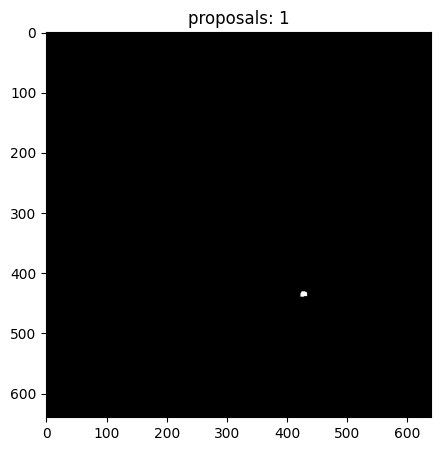

Boxes: [(423, 431, 434, 440)]


In [8]:
# Cell 5: Candidate proposal generator (color-based for blue microplastics)
# This uses HSV thresholding to detect blue-ish spots. Tune thresholds if necessary.
from PIL import Image
def proposals_from_image(img_pil, min_area=20, debug=False):
    # returns list of boxes [xmin,ymin,xmax,ymax]
    img = np.array(img_pil)  # H,W,3, RGB
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # blue-ish HSV range: tune if necessary
    lower = np.array([90, 40, 40])   # H: 90-140 works for many blues
    upper = np.array([160, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    # morphological clean
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    # find connected components / contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    h, w = mask.shape
    for cnt in contours:
        x,y,ww,hh = cv2.boundingRect(cnt)
        area = ww*hh
        if area >= min_area:
            xmin = max(0, x)
            ymin = max(0, y)
            xmax = min(w, x+ww)
            ymax = min(h, y+hh)
            boxes.append((xmin, ymin, xmax, ymax))
    if debug:
        # show mask overlay
        plt.figure(figsize=(5,5))
        plt.imshow(mask, cmap='gray')
        plt.title(f"proposals: {len(boxes)}")
        plt.show()
    return boxes

# quick visual test on first image
sample_img_path = DATA_ROOT / train_df.iloc[0]["filename"]
img = read_image(sample_img_path)
boxes = proposals_from_image(img, debug=True)
print("Boxes:", boxes[:8])


In [9]:
# Cell 6: Compute CLIP embeddings for crops (caches to disk)
# We'll compute embeddings for:
# - all annotated boxes (these are labeled training examples)
# - candidate proposals (for unlabeled images) which we can classify later

EMBED_DIR = Path("embeddings")
EMBED_DIR.mkdir(exist_ok=True)
from tqdm.notebook import tqdm
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast


# Cell 3: Load CLIP model & processor (from transformers)
clip_model_name = "openai/clip-vit-base-patch32"  # reliable default
clip = CLIPModel.from_pretrained(clip_model_name).to(DEVICE)
processor = CLIPProcessor.from_pretrained(clip_model_name)
tokenizer = CLIPTokenizerFast.from_pretrained(clip_model_name)



def embed_image_crop(pil_img):
    inputs = processor(images=pil_img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        img_feats = clip.get_image_features(**inputs)  # shape (1, dim)
        img_feats = img_feats / img_feats.norm(p=2, dim=-1, keepdim=True)
    return img_feats.cpu().numpy().squeeze()

def compute_and_cache_train_embeddings(train_csv_folder, out_npz="train_embeddings.npz", force=False):
    outp = EMBED_DIR / out_npz
    if outp.exists() and not force:
        print("Found cached embeddings:", outp)
        return np.load(outp, allow_pickle=True)
    df = load_annotations_csv(train_csv_folder)
    imgs = []
    embeddings = []
    labels = []
    metas = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = Path(train_csv_folder) / row["filename"]
        img_pil = read_image(img_path)
        bbox = (int(row["xmin"]), int(row["ymin"]), int(row["xmax"]), int(row["ymax"]))
        crop = crop_box(img_pil, bbox)
        emb = embed_image_crop(crop)
        embeddings.append(emb)
        labels.append(1 if str(row["class"]).lower() in ("microplastic","microplastics","microplastic_spot","mp","1") else 0)
        metas.append({"filename": str(row["filename"]), "bbox": bbox})
    embeddings = np.stack(embeddings, axis=0).astype(np.float32)
    labels = np.array(labels, dtype=np.int64)
    np.savez(outp, embeddings=embeddings, labels=labels, metas=metas)
    print("Saved embeddings:", outp)
    return np.load(outp, allow_pickle=True)

train_data = compute_and_cache_train_embeddings(DATA_ROOT)
print("Train embeddings shape:", train_data["embeddings"].shape)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Found cached embeddings: embeddings/train_embeddings.npz
Train embeddings shape: (2845, 512)


In [10]:
# Cell 7: Build and train a small TF classifier on top of CLIP embeddings
# We'll use a tiny MLP in TF. Use early stopping to avoid overfitting.
X = train_data["embeddings"]
y = train_data["labels"]

# Shuffle & train/val split
rng = np.random.RandomState(42)
perm = rng.permutation(len(X))
X = X[perm]
y = y[perm]
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

def build_classifier(input_dim, lr=1e-3):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss=losses.BinaryCrossentropy(),
                  metrics=["accuracy"])
    return model

clf = build_classifier(X_train.shape[1])
es = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
history = clf.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[es])


I0000 00:00:1763070211.811022   14528 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4926 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/50


2025-11-14 03:43:32.738123: I external/local_xla/xla/service/service.cc:163] XLA service 0x70dfe8006330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-14 03:43:32.738145: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-11-14 03:43:32.751746: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-14 03:43:32.852420: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-14 03:43:32.914168: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-14 03:43:32.914208: 

71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8481 - loss: 0.4350

I0000 00:00:1763070214.691414   14682 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8492 - loss: 0.4323

2025-11-14 03:43:36.017232: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-14 03:43:36.207165: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27', 8 bytes spill stores, 8 bytes spill loads

2025-11-14 03:43:36.741845: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-14 03:43:36.931975: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8503 - loss: 0.4297 - val_accuracy: 0.9965 - val_loss: 0.0174
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9971 - loss: 0.0196 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 8.3277e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9982 - val_loss: 0.0041
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 3.4861e-04
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Preds: []


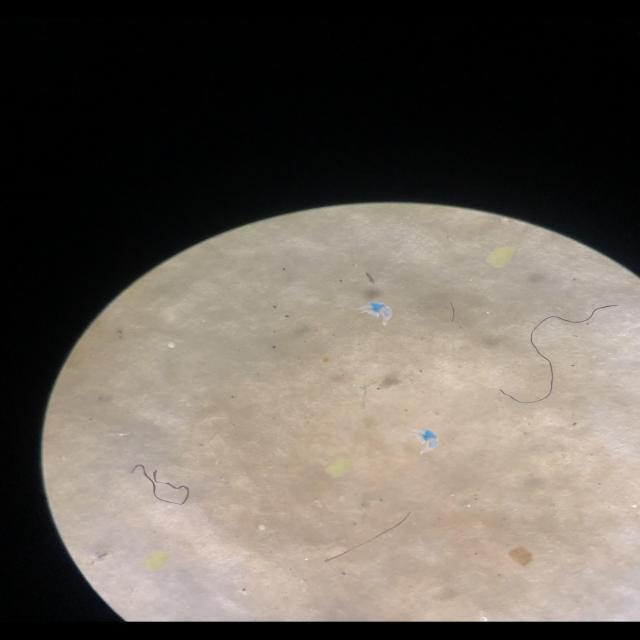

In [11]:
# Cell 8: Inference - detection on new images using proposals -> CLIP emb -> classifier
# returns list of predicted boxes with score
def detect_microplastics_in_image(img_pil, classifier, clip_model, threshold=0.5, min_area=20):
    boxes = proposals_from_image(img_pil, min_area=min_area, debug=False)
    predictions = []
    for bbox in boxes:
        crop = crop_box(img_pil, bbox)
        emb = embed_image_crop(crop)  # numpy vector
        score = classifier.predict(emb.reshape(1,-1))[0,0]  # sigmoid score
        if score >= threshold:
            predictions.append({"bbox": bbox, "score": float(score)})
    return predictions

# Visualize detection example on a validation image
val_sample_path = VALID_ROOT / load_annotations_csv(VALID_ROOT).iloc[0]["filename"]
img_val = read_image(val_sample_path)
preds = detect_microplastics_in_image(img_val, clf, clip)
print("Preds:", preds)
# draw detected boxes
draw = ImageDraw.Draw(img_val)
for p in preds:
    draw.rectangle(p["bbox"], outline=(255,0,0), width=2)
    draw.text((p["bbox"][0], p["bbox"][1]-10), f"{p['score']:.2f}", fill=(255,0,0))
display(img_val)


In [12]:
# Cell 9: Build FAISS index for all training crop embeddings (for retrieval)
# We'll index the same embeddings we used for training so we can retrieve similar patches.
train_npz = train_data
embs = train_npz["embeddings"].astype(np.float32)
n, d = embs.shape
index = faiss.IndexFlatIP(d)  # inner product on normalized vectors = cosine
# Note: CLIP embeddings are normalized already in our pipeline, but ensure normalization
faiss.normalize_L2(embs)
index.add(embs)
print("FAISS index size:", index.ntotal)

# Save index and metadata
faiss.write_index(index, str(EMBED_DIR/"faiss.index"))
import json
with open(EMBED_DIR/"meta.json","w") as f:
    json.dump([dict(m) for m in train_npz["metas"]], f)
print("Saved FAISS index and metadata")


FAISS index size: 2845
Saved FAISS index and metadata


In [13]:
# Cell 10: RAG-style retrieval + generation
# We'll create a simple function:
# 1) embed user text query with CLIP text encoder
# 2) retrieve top-k patch embeddings from FAISS (by similarity)
# 3) prepare a small prompt from retrieved patch metadata
# 4) call T5 to generate an answer
t5_model_name = "t5-small"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5 = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(DEVICE)

# Load FAISS index and metadata
index = faiss.read_index(str(EMBED_DIR/"faiss.index"))
import json
meta = json.load(open(EMBED_DIR/"meta.json","r"))

def embed_text_clip(prompt):
    inputs = processor(text=[prompt], images=None, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        text_feats = clip.get_text_features(**inputs)
        text_feats = text_feats / text_feats.norm(p=2, dim=-1, keepdim=True)
    return text_feats.cpu().numpy().astype(np.float32).squeeze()

def rag_query(query, top_k=5):
    q_emb = embed_text_clip(query)
    faiss.normalize_L2(q_emb.reshape(1,-1))
    D, I = index.search(q_emb.reshape(1,-1), top_k)
    results = []
    for dist, idx in zip(D[0], I[0]):
        m = meta[idx]
        results.append({"meta": m, "score": float(dist)})
    # assemble prompt for generator
    context_lines = []
    for r in results:
        m = r["meta"]
        context_lines.append(f"Image: {m['filename']}, bbox: {m['bbox']}, label: microplastic (train example)")
    context = "\n".join(context_lines)
    prompt = f"Context:\n{context}\n\nQuestion: {query}\nAnswer:"
    # generate
    input_ids = t5_tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).input_ids.to(DEVICE)
    out = t5.generate(input_ids, max_length=128, num_beams=3)
    ans = t5_tokenizer.decode(out[0], skip_special_tokens=True)
    return {"answer": ans, "retrieved": results}

# Example query
res = rag_query("Where are microplastics visible and how confident are you?")
print("Generated answer:\n", res["answer"])
print("Retrieved examples:", res["retrieved"])


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generated answer:
 115_png_jpg.rf.5cacb3f5c8db7aa48c655da0b731f47d.jpg, bbox: [562, 464, 603, 502], label: microplastic (train example) Image: 115_png_jpg.rf.5cacb3f5c8db7aa48c655da0b731f47d.jpg, bbox: [4
Retrieved examples: [{'meta': {'filename': '115_png_jpg.rf.5cacb3f5c8db7aa48c655da0b731f47d.jpg', 'bbox': [562, 464, 603, 502]}, 'score': 0.2589368522167206}, {'meta': {'filename': '10_png_jpg.rf.fe502b4348a2b36cbfe3cd86b66540ee.jpg', 'bbox': [499, 544, 531, 575]}, 'score': 0.25090986490249634}, {'meta': {'filename': '398-d_png_jpg.rf.774144cd665defe250512b5b664e5d28.jpg', 'bbox': [388, 428, 427, 456]}, 'score': 0.2499534785747528}, {'meta': {'filename': '115_png_jpg.rf.5cacb3f5c8db7aa48c655da0b731f47d.jpg', 'bbox': [405, 423, 446, 460]}, 'score': 0.24608482420444489}, {'meta': {'filename': '244-b_png_jpg.rf.fbc5adc548e84bc5d8f4707dad75606a.jpg', 'bbox': [273, 311, 333, 346]}, 'score': 0.24542586505413055}]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


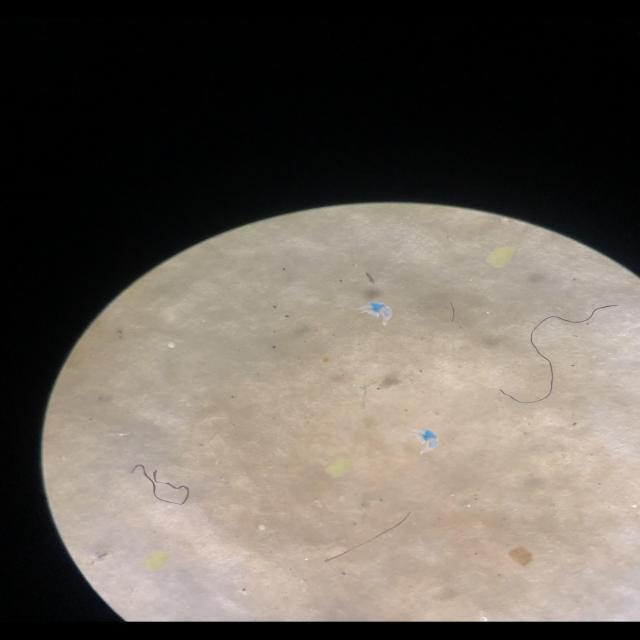

[]

In [15]:
# Cell 11: Put it together in an inference wrapper that:
# - runs detection on a given image
# - retrieves nearest training patches for each detected crop and
# - generates an explanation/report per image
def process_image_with_rag(image_path, classifier, top_k=3, detection_thresh=0.5):
    img_pil = read_image(image_path)
    predictions = detect_microplastics_in_image(img_pil, classifier, clip, threshold=detection_thresh)
    reports = []
    for p in predictions:
        crop = crop_box(img_pil, p["bbox"])
        emb = embed_image_crop(crop).astype(np.float32)
        faiss.normalize_L2(emb.reshape(1,-1))
        D,I = index.search(emb.reshape(1,-1), top_k)
        retrieved = [meta[i] for i in I[0]]
        # build prompt & generate
        ctx_lines = []
        for r in retrieved:
            ctx_lines.append(f"Image {r['filename']} bbox {r['bbox']}")
        context = "\n".join(ctx_lines)
        prompt = f"Context:\n{context}\n\nDescribe whether this crop is a microplastic and why."
        input_ids = t5_tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).input_ids.to(DEVICE)
        out = t5.generate(input_ids, max_length=64, num_beams=3)
        ans = t5_tokenizer.decode(out[0], skip_special_tokens=True)
        reports.append({"bbox": p["bbox"], "score": p["score"], "explanation": ans, "retrieved": retrieved})
    # annotate image
    annotated = img_pil.copy()
    draw = ImageDraw.Draw(annotated)
    for r in reports:
        draw.rectangle(r["bbox"], outline=(255,0,0), width=2)
        draw.text((r["bbox"][0], r["bbox"][1]-12), f"{r['score']:.2f}", fill=(255,0,0))
    return annotated, reports

# Test on a validation image
test_img = VALID_ROOT / load_annotations_csv(VALID_ROOT).iloc[0]["filename"]
annot, reports = process_image_with_rag(test_img, clf)
display(annot)
reports


In [16]:
# Cell 12: Utility scripts & tips
# Save detection results as CSV (image, xmin,ymin,xmax,ymax,score)
def save_detections_for_folder(folder_path, classifier, out_csv="detections.csv", threshold=0.5):
    folder = Path(folder_path)
    ann = load_annotations_csv(folder)
    rows = []
    unique_files = ann["filename"].unique()
    for fn in tqdm(unique_files):
        img_path = folder / fn
        if not img_path.exists():
            continue
        img = read_image(img_path)
        preds = detect_microplastics_in_image(img, classifier, clip, threshold)
        for p in preds:
            xmin,ymin,xmax,ymax = p["bbox"]
            rows.append({"filename":fn,"xmin":xmin,"ymin":ymin,"xmax":xmax,"ymax":ymax,"score":p["score"]})
    pd.DataFrame(rows).to_csv(folder / out_csv, index=False)
    print("Saved to", folder / out_csv)

# Example:
# save_detections_for_folder("valid", clf)


In [17]:
# Cell: Evaluation utilities + detection & classification metrics on "valid"
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw

VALID_ROOT = Path("valid")  # adjust if needed

# --- helper: IoU ---
def iou(boxA, boxB):
    # boxes: (xmin,ymin,xmax,ymax)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    if interArea == 0:
        return 0.0
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = boxAArea + boxBArea - interArea
    return interArea / union if union > 0 else 0.0

# --- load validation annotations ---
val_df = load_annotations_csv(VALID_ROOT)  # uses previously defined function
# group by filename
grouped = val_df.groupby("filename")

# parameters
IOU_THRESH = 0.5
DETECTION_SCORE_THRESH = 0.5  # same as used during inference
MIN_AREA = 20

# global counters
TP = 0
FP = 0
FN = 0

# store per-image details if you want to inspect later
per_image_stats = []

for fname, ann in tqdm(grouped, total=len(grouped)):
    img_path = VALID_ROOT / fname
    if not img_path.exists():
        continue
    img_pil = read_image(img_path)
    # ground-truth boxes for this image (only consider positive class labels)
    # we assume "class" column contains labels; treat non-empty as positive microplastic if label indicates so
    gt_boxes = []
    for _, row in ann.iterrows():
        cls = str(row["class"]).lower()
        # consider classes that indicate microplastics as positive;
        # if your dataset uses "microplastic" or "mp" or "1", modify the check as necessary
        if cls in ("microplastic","microplastics","microplastic_spot","mp","1","positive","pos","true","t","yes","y"):
            gt_boxes.append((int(row["xmin"]), int(row["ymin"]), int(row["xmax"]), int(row["ymax"])))
    # run detector on this image (proposals + classifier)
    preds = detect_microplastics_in_image(img_pil, clf, clip, threshold=DETECTION_SCORE_THRESH, min_area=MIN_AREA)
    pred_boxes = [p["bbox"] for p in preds]
    pred_scores = [p["score"] for p in preds]
    matched_gt = set()
    matched_pred = set()

    # greedy matching: for each prediction, match best GT by IoU if >= IOU_THRESH and not already matched
    for p_idx, pbox in enumerate(pred_boxes):
        best_iou = 0.0
        best_gt_idx = -1
        for g_idx, gbox in enumerate(gt_boxes):
            if g_idx in matched_gt:
                continue
            cur_iou = iou(pbox, gbox)
            if cur_iou > best_iou:
                best_iou = cur_iou
                best_gt_idx = g_idx
        if best_iou >= IOU_THRESH:
            TP += 1
            matched_gt.add(best_gt_idx)
            matched_pred.add(p_idx)
        else:
            FP += 1  # predicted box not matched sufficiently
    # any GT not matched -> false negative
    FN += (len(gt_boxes) - len(matched_gt))

    per_image_stats.append({
        "filename": fname,
        "n_gt": len(gt_boxes),
        "n_pred": len(pred_boxes),
        "n_matched": len(matched_gt),
    })

# compute metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print("Detection evaluation (IoU thresh = %.2f, score thresh = %.2f):" % (IOU_THRESH, DETECTION_SCORE_THRESH))
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Optional: show a small table of worst images (many FP or FN)
per_df = pd.DataFrame(per_image_stats)
per_df["missed"] = per_df["n_gt"] - per_df["n_matched"]
per_df.sort_values(["missed","n_pred"], ascending=[False,False]).head(10)


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

,filename,n_gt,n_pred,n_matched,missed
0,100_png_jpg.rf.2166eb85c33730f97506aa5615420f7...,0,0,0,0
1,11_png_jpg.rf.5a826d0d38d6b68270019a9faaf46a40...,0,0,0,0
2,12_png_jpg.rf.f39fb0e314cfa61eed987a0b142ad45a...,0,0,0,0
3,14_png_jpg.rf.7a8425abcb1d2794e736885a580fa0d6...,0,0,0,0
4,16_png_jpg.rf.5b3d9962cecf551abf779ebb324c61d1...,0,0,0,0
5,17_png_jpg.rf.90612decd1c215f6ca8f9b2c1b0968f4...,0,0,0,0
6,18_png_jpg.rf.2ed370829e1cf29ebb5f168a1d914d66...,0,0,0,0
7,19_png_jpg.rf.fc11cca083998a10f0ddd198143c088d...,0,0,0,0
8,1_png_jpg.rf.6b62627ba6ca5b6ba1f3adb8fd79bb9f.jpg,0,0,0,0
9,20_png_jpg.rf.aa3d012e1ad0b872bc86cd6582413436...,0,0,0,0


  0%|          | 0/688 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

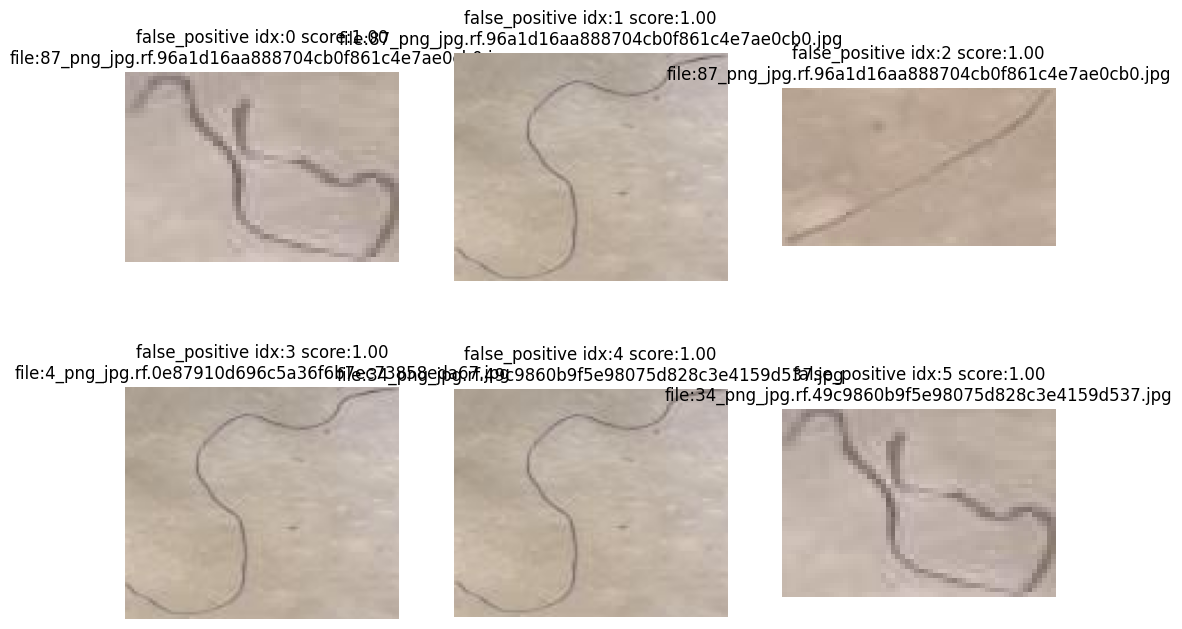

In [18]:
# Cell: Crop classification accuracy on validation annotations
# This evaluates how well the classifier labels the ground-truth crops.
# We'll read each annotation row, crop, embed, predict, and compare to the label.

# Threshold for classifier decision
CLS_THRESH = 0.5

y_true = []
y_scores = []
y_pred = []

for _, row in tqdm(val_df.iterrows(), total=len(val_df)):
    img_path = VALID_ROOT / row["filename"]
    if not img_path.exists():
        continue
    img_pil = read_image(img_path)
    bbox = (int(row["xmin"]), int(row["ymin"]), int(row["xmax"]), int(row["ymax"]))
    crop = crop_box(img_pil, bbox)
    emb = embed_image_crop(crop)  # numpy vector
    score = float(clf.predict(emb.reshape(1,-1))[0,0])  # classifier output probability
    # determine true label
    cls = str(row["class"]).lower()
    true_label = 1 if cls in ("microplastic","microplastics","microplastic_spot","mp","1","positive","pos","true","t","yes","y") else 0
    y_true.append(true_label)
    y_scores.append(score)
    y_pred.append(1 if score >= CLS_THRESH else 0)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

tp = int(((y_pred==1) & (y_true==1)).sum())
tn = int(((y_pred==0) & (y_true==0)).sum())
fp = int(((y_pred==1) & (y_true==0)).sum())
fn = int(((y_pred==0) & (y_true==1)).sum())

acc = (tp + tn) / (tp + tn + fp + fn)
prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1 = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0

print("Crop-classification metrics (threshold=%.2f):" % CLS_THRESH)
print(f"Samples: {len(y_true)}  Accuracy: {acc:.4f}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

# Optional: show some false positives and false negatives for inspection
import itertools
false_pos_idx = np.where((y_pred==1) & (y_true==0))[0]
false_neg_idx = np.where((y_pred==0) & (y_true==1))[0]

def show_examples(indices, kind="fp", n=6):
    indices = list(indices)[:n]
    imgs = []
    for idx in indices:
        row = val_df.iloc[idx]
        img_p = VALID_ROOT / row["filename"]
        img = read_image(img_p)
        bbox = (int(row["xmin"]), int(row["ymin"]), int(row["xmax"]), int(row["ymax"]))
        crop = crop_box(img, bbox)
        imgs.append((crop, row, float(clf.predict(embed_image_crop(crop).reshape(1,-1))[0,0])))
    # display
    import matplotlib.pyplot as plt
    cols = min(len(imgs), 3)
    rows = (len(imgs) + cols - 1) // cols
    plt.figure(figsize=(4*cols, 4*rows))
    for i, (crop, row, score) in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(crop)
        plt.axis("off")
        plt.title(f"{kind} idx:{i} score:{score:.2f}\nfile:{row['filename']}")
    plt.show()

# Inspect a few false positives and false negatives if they exist
if len(false_pos_idx)>0:
    print("Showing a few false positives:")
    show_examples(false_pos_idx, kind="false_positive", n=6)
if len(false_neg_idx)>0:
    print("Showing a few false negatives:")
    show_examples(false_neg_idx, kind="false_negative", n=6)
